In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

from pygit2 import Repository
import time
from dotenv import load_dotenv
import mlflow
import matplotlib.pyplot as plt
import numpy as np
import sys  
sys.path.insert(0, '../src/data/')
from dataset_generators import *

load_dotenv()

True

In [2]:
test_mask_dir = "../data/processed/test/mask/"
test_img_dir = "../data/processed/test/img/"

train_dir = "../data/processed/train/"
val_dir = "../data/processed/validation/"
test_dir = "../data/processed/test/"

# Нейронная сеть

## Архитектура сети

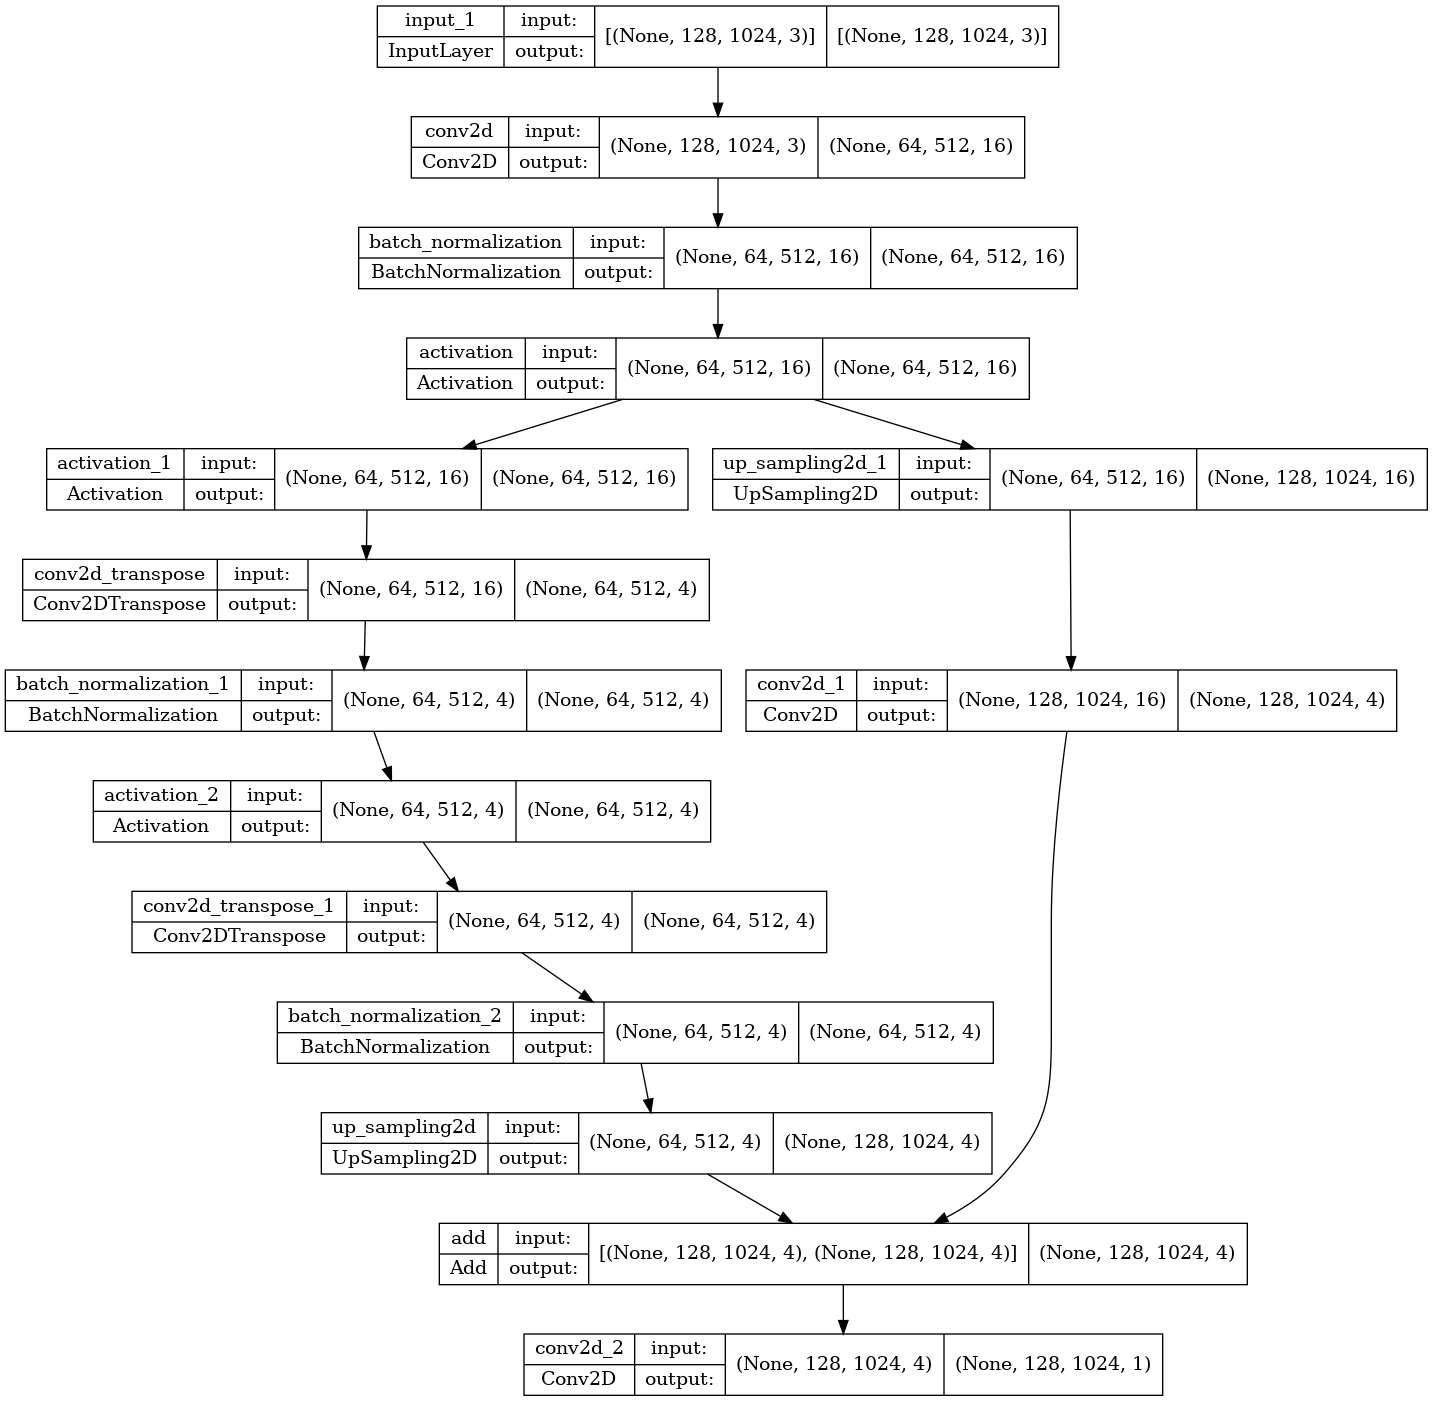

In [3]:
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (CHANNELS,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in []:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [4]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

## Model compile

In [4]:
# define optomizer
optim = keras.optimizers.Adam(0.001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

## Callbacks

In [5]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=1):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(20, 20))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Data generators

In [6]:
train_datagen = img_mask_generator(train_dir, batch_size=16)
val_datagen = img_mask_generator(val_dir, batch_size=16)

## Model Training

Epoch 1/10
200/200 [==============================] - 8s 29ms/step - loss: 0.1046 - accuracy: 0.9935 - val_loss: 0.0384 - val_accuracy: 0.9953
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9975

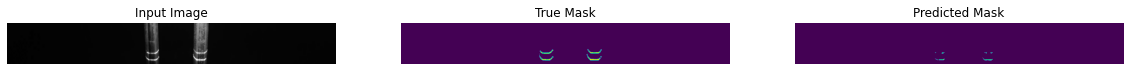


Sample Prediction after epoch 2

200/200 [==============================] - 6s 30ms/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0129 - val_accuracy: 0.9959
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9976

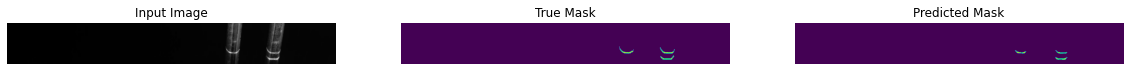


Sample Prediction after epoch 3

200/200 [==============================] - 6s 29ms/step - loss: 0.0046 - accuracy: 0.9976 - val_loss: 0.0050 - val_accuracy: 0.9974
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9977

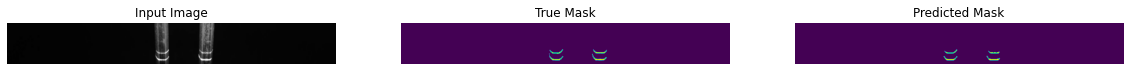


Sample Prediction after epoch 4

200/200 [==============================] - 6s 29ms/step - loss: 0.0039 - accuracy: 0.9977 - val_loss: 0.0040 - val_accuracy: 0.9976
Epoch 5/10
199/200 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9977

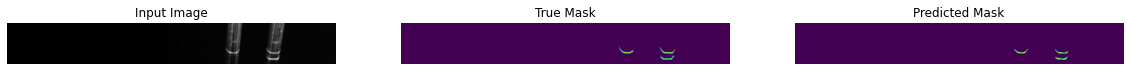


Sample Prediction after epoch 5

200/200 [==============================] - 6s 29ms/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9977
Epoch 6/10
199/200 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9977

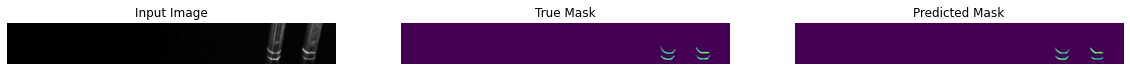


Sample Prediction after epoch 6

200/200 [==============================] - 6s 29ms/step - loss: 0.0032 - accuracy: 0.9977 - val_loss: 0.0033 - val_accuracy: 0.9978
Epoch 7/10
199/200 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9977

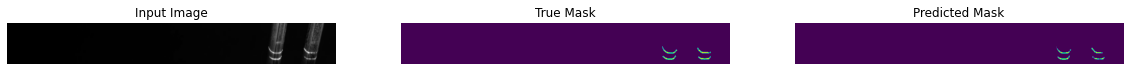


Sample Prediction after epoch 7

200/200 [==============================] - 6s 29ms/step - loss: 0.0032 - accuracy: 0.9977 - val_loss: 0.0031 - val_accuracy: 0.9978
Epoch 8/10
199/200 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9977

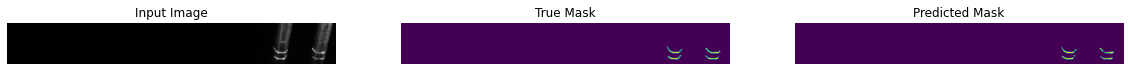


Sample Prediction after epoch 8

200/200 [==============================] - 6s 29ms/step - loss: 0.0032 - accuracy: 0.9977 - val_loss: 0.0031 - val_accuracy: 0.9978
Epoch 9/10
115/200 [================>.............] - ETA: 2s - loss: 0.0033 - accuracy: 0.9977WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


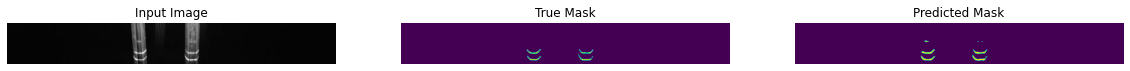


Sample Prediction after epoch 9

200/200 [==============================] - 4s 19ms/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 0.0061 - val_accuracy: 0.9972
INFO:tensorflow:Assets written to: /tmp/tmp0ivzcqsy/model/data/model/assets


In [7]:
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.tensorflow.autolog()
mlflow.set_experiment(experiment_name=Repository('.').head.shorthand)

with mlflow.start_run():
    epochs = 10
    model.fit(
        train_datagen,
        steps_per_epoch=200,
        epochs=epochs,
        validation_data=val_datagen,
        validation_steps=20,
        callbacks=[DisplayCallback(train_datagen)]
    )
    
    
    time_of_prediction_array = np.zeros(100)
    
    test_image_path = '../data/processed/test/img/210416D.003_1400701D.E003_96860_2.jpg'
    test_img = read_data_img(test_image_path)
    test_img = tf.reshape(test_img, [1, 128, 1024, CHANNELS])
    
    for i in range(100):
        
        start = time.perf_counter()
        mask = model.predict(test_img)
        end = time.perf_counter()
        
        time_of_prediction_array[i] = end - start
        
    speed_metrics = {'pred_time': time_of_prediction_array[1:].mean(),
                     'RMSE_pred_time': time_of_prediction_array[1:].std() }    
    mlflow.log_metrics(speed_metrics)

## Model Test

In [8]:
test_image_path = '../data/processed/test/img/210416D.003_1400701D.E003_96860_2.jpg'
test_img = read_data_img(test_image_path)
test_img = tf.reshape(test_img, [1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS])

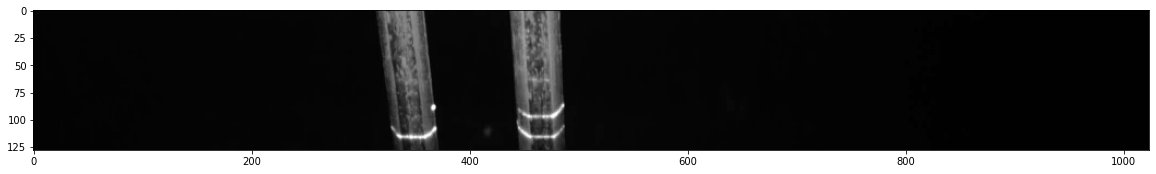

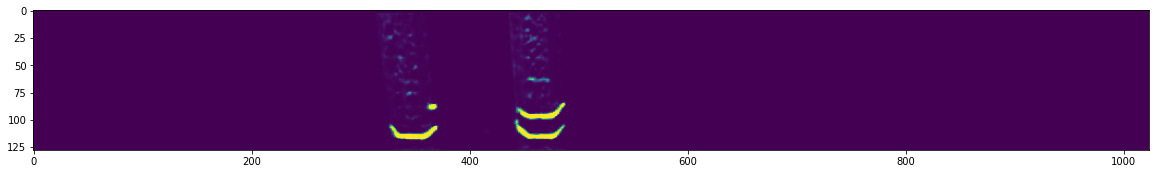

In [9]:
plt.figure(figsize=(20, 10))
plt.imshow(test_img[0])
plt.figure(figsize=(20, 10))
plt.imshow(mask[0])